In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
from PIL import Image
import numpy as np
#from torch import mps


#### Load dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3104575..1.7135221].


Classes: ['Apple', 'Ball', 'Bird', 'Car', 'Dog', 'Plane']
Custom dataset size: 57 imgs


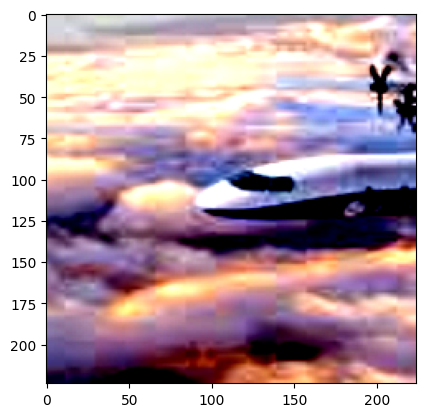

Label of img: Plane


In [10]:
data_dir = '/Users/jli28/Desktop/Dataset'
train_path = os.path.join(data_dir, 'train')

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {'train': datasets.ImageFolder(train_path, data_transforms['train'])}

dataloaders = {'train': DataLoader(image_datasets['train'], batch_size = 6, shuffle = True, num_workers = 0)}

dataset_sizes = {'train': len(image_datasets['train'])}

class_names = image_datasets['train'].classes

print(f"Classes: {class_names}")
print(f"Custom dataset size: {dataset_sizes['train']} imgs")

inputs, labels = next(iter(dataloaders['train']))

# See imgs using matplotlib:
def imshow(img):
    #img = img / 2 + 0.5 #Unnormalize? ('?')
    img = img / 1.5 # Changing pixel intensity
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #Flip img correctly and dont go oob
    plt.show()

imshow(inputs[0].cpu())
print("Label of img:", class_names[labels[0]])

#### Build nn (ResNet)

In [11]:
model = models.resnet152(pretrained = True) #imagenet, has relu built in not tanh or sigmoid

for param in model.parameters():
    param.requires_grad = False

# Num of input features for final fcl
num_ftrs = model.fc.in_features

num_classes = len(class_names)
model.fc = nn.Linear(num_ftrs, num_classes)

# I dont have cuda :(
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
model = model.to(device)

print(model)

/Users/jli28/.pyenv/versions/3.11.1/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jli28/.pyenv/versions/3.11.1/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Loss function & optimizer

In [12]:
criterion = nn.CrossEntropyLoss() # cross entropy loss function

# optimize final fcl w/ Adam
optimizer = optim.Adam(model.fc.parameters(), lr=0.01) #small learning rate but more precision
#ptimizer = optim.Adadelta(model)

# SGD (stochastic gradient descent)
#optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

#### Train the nn

In [13]:
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs = 15):

    model.train() # Pytorch training mode

    for epoch in range(num_epochs):

        print(f'Epoch {epoch + 1}')

        running_loss = 0
        running_corrects = 0

        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # Needed to not accum past gradients vvv

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) # Thing with max probabbility

            loss = criterion(outputs, labels)

            loss.backward() # Calculate gradients (backpropagation)
            optimizer.step() # Update the params

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects / dataset_sizes['train']

        print(f'Loss: {epoch_loss:.2f} Accuracy: {epoch_acc:.2f}')
        print()

    return model

num_epochs = 15 # more epochs bc small dataset so why not :/
trained_model = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs)

print("TRAINING DONE! :D")

Epoch 1
Loss: 6.65 Accuracy: 0.44

Epoch 2
Loss: 1.93 Accuracy: 0.72

Epoch 3
Loss: 0.76 Accuracy: 0.82

Epoch 4
Loss: 0.36 Accuracy: 0.88

Epoch 5
Loss: 0.48 Accuracy: 0.89

Epoch 6
Loss: 0.19 Accuracy: 0.96

Epoch 7
Loss: 0.28 Accuracy: 0.95

Epoch 8
Loss: 0.02 Accuracy: 0.98

Epoch 9
Loss: 0.05 Accuracy: 0.98

Epoch 10
Loss: 0.08 Accuracy: 0.98

Epoch 11
Loss: 0.44 Accuracy: 0.91

Epoch 12
Loss: 0.71 Accuracy: 0.88

Epoch 13
Loss: 1.05 Accuracy: 0.84

Epoch 14
Loss: 0.30 Accuracy: 0.98

Epoch 15
Loss: 0.17 Accuracy: 0.95

TRAINING DONE! :D


#### Generate predictions

In [15]:
def predict_image(model, image_path, class_names, transforms, device):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transforms(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad(): # No grad calculation for inference, no backpropogation tho
        output = model(image_tensor)
        _, predicted_index = torch.max(output, 1) # Choose max likelihood
        prediction = class_names[predicted_index[0]]
        probability = torch.softmax(output, dim = 1)[0][predicted_index[0]].item()

    return prediction, probability

#### Run predictions

In [16]:
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
test_img_path = os.path.join(desktop_path, "appleTest.jpg")

print(f"Opening img at: '{test_img_path}'")

try:
    prediction, probability = predict_image(trained_model, test_img_path, class_names, data_transforms['train'], device)
    print(f"Predicted class: {prediction}")
    print(f"Confidence: {probability:.2f}")

except FileNotFoundError:
    print(f"Err: img not found '{test_img_path}'")
except Exception as e:
    print(f"Err: {e}")

Opening img at: '/Users/jli28/Desktop/appleTest.jpg'
Predicted class: Apple
Confidence: 1.00


In [14]:
#Random stuff idk lol
cube = {{5, 1, 7}, {6, 1, 2}, {3, 10, 5}}, {{1, 2, 3}, {4, 5, 6}, {7, 8, 9}}, {{1, 2, 3}, {4, 5, 6}, {7, 8, 9}}
print(cube)


TypeError: unhashable type: 'set'